# A Unified View of Entropy-Regularized Markov Decision Processes:
## Article Review



In [17]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from renderer import *
from gridworld import *

import scipy
import scipy.optimize as opt
import pdb

In [2]:
grid1 = [
    ['', '', '', 1],
    ['', 'x', '', -1],
    ['', '', '', '']
]

env = GridWorld(gamma=0.95, grid=grid1)

In [3]:
class Policy(object):
    def __init__(self,pi):
        n_states,n_actions = np.shape(pi)
        self.n_actions = n_actions
        self.n_states = n_states
        self.pi = pi
    def draw_action(self,state):
        u = np.random.rand()
        probas = np.cumsum(self.pi[state,:])
        a = 0
        while (a < self.n_actions-1 and (u > probas[a] or self.pi[state,a]==0)):
            a += 1
        return a

In [91]:
class RLModel:
    def __init__(self, env):
        self.env = env
        self.moving_rewards = []
        self.episode_count = 0

    def initialize_pi(self):
        pi = np.zeros((self.env.n_states,self.env.n_actions))
        for s in range(self.env.n_states):
            actions = self.env.state_actions[s]
            for a in actions:
                pi[s,a] = 1./len(actions)
        return pi
    
    def collect_episodes(self, policy=None, horizon=None, n_episodes=1, render=False):
        paths = []

        for _ in range(n_episodes):
            observations = []
            actions = []
            rewards = []
            next_states = []

            state = self.env.reset()
            ep_r = 0
            for _ in range(horizon):
                action = policy.draw_action(state)
                next_state, reward, terminal = self.env.step(state,action)
                ep_r += reward
                if render:
                    self.env.render()
                observations.append(state)
                actions.append(action)
                rewards.append(reward)
                next_states.append(next_state)
                state = copy.copy(next_state)
                if terminal:
                    # Finish rollout if terminal state reached
                    if len(self.moving_rewards) == 0:  # record running episode reward
                        self.moving_rewards.append(ep_r)
                    else:
                        self.moving_rewards.append(0.9 * self.moving_rewards[-1] + 0.1 * ep_r)
                    self.episode_count += 1
                    break
                    # We need to compute the empirical return for each time step along the
                    # trajectory
            paths.append(dict(
                states=np.array(observations),
                actions=np.array(actions),
                rewards=np.array(rewards),
                next_states=np.array(next_states)
            ))
        return paths

    
    def render_policy(self):
        render_policy(self.env,self.policy.pi)
        
    def plot_avg_moving_rwd(self,name):
        avg_moving_reward = self.moving_rewards
        plt.plot(np.arange(len(avg_moving_reward)), avg_moving_reward)
        plt.xlabel('Step')
        plt.ylabel('Total moving reward')
        plt.savefig(name)
        plt.title(name)
        plt.show()

## DQN

In [24]:
import numpy as np
import pandas as pd
import tensorflow as tf

np.random.seed(1)
tf.set_random_seed(1)


class DeepQNetwork(RLModel):
    def __init__(self, env, e_greedy_increment=None):
        RLModel.__init__(self, env)
        self.n_actions = env.n_actions
        self.n_features = 1
        self.lr = 0.0001
        self.gamma = 0.9
        self.epsilon_max = 0.9
        self.replace_target_iter = 150
        self.memory_size = 2000
        self.batch_size = 32
        self.epsilon_increment = e_greedy_increment
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max

        # total learning step
        self.learn_step_counter = 0

        # initialize zero memory [s, a, r, s_]
        self.memory = np.zeros((self.memory_size, self.n_features * 2 + 2))

        # consist of [target_net, evaluate_net]
        self._build_net()
        t_params = tf.get_collection('target_net_params')
        e_params = tf.get_collection('eval_net_params')
        self.replace_target_op = [tf.assign(t, e) for t, e in zip(t_params, e_params)]

        self.sess = tf.Session()

        self.sess.run(tf.global_variables_initializer())
        self.cost_his = []

    def _build_net(self):
        # ------------------ build evaluate_net ------------------
        self.s = tf.placeholder(tf.float32, [None,1], name='s')  # input
        self.q_target = tf.placeholder(tf.float32, [None, self.n_actions], name='Q_target')  # for calculating loss
        with tf.variable_scope('eval_net'):
            # c_names(collections_names) are the collections to store variables
            c_names, n_l1, w_initializer, b_initializer = \
                ['eval_net_params', tf.GraphKeys.GLOBAL_VARIABLES], 10, \
                tf.random_normal_initializer(0., 0.3), tf.constant_initializer(0.1)  # config of layers

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [1,n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1,n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(self.s* w1 + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1, self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_eval = tf.matmul(l1, w2) + b2

        with tf.variable_scope('loss'):
            self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        with tf.variable_scope('train'):
            self._train_op = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss)

        # ------------------ build target_net ------------------
        self.s_ = tf.placeholder(tf.float32, [None,1], name='s_')    # input
        with tf.variable_scope('target_net'):
            # c_names(collections_names) are the collections to store variables
            c_names = ['target_net_params', tf.GraphKeys.GLOBAL_VARIABLES]

            # first layer. collections is used later when assign to target net
            with tf.variable_scope('l1'):
                w1 = tf.get_variable('w1', [1,n_l1], initializer=w_initializer, collections=c_names)
                b1 = tf.get_variable('b1', [1,n_l1], initializer=b_initializer, collections=c_names)
                l1 = tf.nn.relu(self.s_ * w1 + b1)

            # second layer. collections is used later when assign to target net
            with tf.variable_scope('l2'):
                w2 = tf.get_variable('w2', [n_l1, self.n_actions], initializer=w_initializer, collections=c_names)
                b2 = tf.get_variable('b2', [1,self.n_actions], initializer=b_initializer, collections=c_names)
                self.q_next = tf.matmul(l1, w2) + b2

    def store_transition(self, s, a, r, s_):
        if not hasattr(self, 'memory_counter'):
            self.memory_counter = 0

        # replace the old memory with new memory
        index = self.memory_counter % self.memory_size
        self.memory[index, :] = [s, a, r, s_]

        self.memory_counter += 1

    def choose_action(self, observation):
        # to have batch dimension when feed into tf placeholder
        observation = observation[np.newaxis]
        observation = np.array(observation).reshape(-1,1)

        if np.random.uniform() < self.epsilon:
            # forward feed the observation and get q value for every actions
            actions_value = self.sess.run(self.q_eval, feed_dict={self.s: observation})
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        return action

    def learn(self):
        # check to replace target parameters
        if self.learn_step_counter % self.replace_target_iter == 0:
            self.sess.run(self.replace_target_op)

        # sample batch memory from all memory
        if self.memory_counter > self.memory_size:
            sample_index = np.random.choice(self.memory_size, size=self.batch_size)
        else:
            sample_index = np.random.choice(self.memory_counter, size=self.batch_size)
        batch_memory = self.memory[sample_index, :]

        q_next, q_eval = self.sess.run(
            [self.q_next, self.q_eval],
            feed_dict={
                self.s_: batch_memory[:, 3].reshape(-1,1),  # fixed params
                self.s: batch_memory[:, 0].reshape(-1,1),  # newest params
            })

        # change q_target w.r.t q_eval's action
        q_target = q_eval.copy()

        batch_index = np.arange(self.batch_size, dtype=np.int32)
        eval_act_index = batch_memory[:, self.n_features].astype(int)
        reward = batch_memory[:, 2]

        q_target[batch_index, eval_act_index] = reward + self.gamma * np.max(q_next, axis=1)

        # train eval network
        _, self.cost = self.sess.run([self._train_op, self.loss],
                                     feed_dict={self.s: batch_memory[:, 0].reshape(-1,1),
                                                self.q_target: q_target})
        self.cost_his.append(self.cost)

        # increasing epsilon
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1

    def plot_cost(self):
        import matplotlib.pyplot as plt
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('Cost')
        plt.xlabel('training steps')
        plt.show()

    def compute_policy(self):
        q = np.zeros((RL.env.n_states,RL.env.n_actions))
        for s in range(RL.env.n_states):
            observation = np.array([s]).reshape(-1,1)
            actions = RL.sess.run(RL.q_eval, feed_dict={RL.s: observation})
            q[s,np.argmax(actions)] = 1
        self.policy = Policy(q)
    
    def compute_q(self):
        q = np.zeros((RL.env.n_states,RL.env.n_actions))
        for s in range(RL.env.n_states):
            observation = np.array([s]).reshape(-1,1)
            actions = RL.sess.run(RL.q_eval, feed_dict={RL.s: observation})
            q[s,:] = actions
        self.q = q 

Computational time :  29.929976224899292


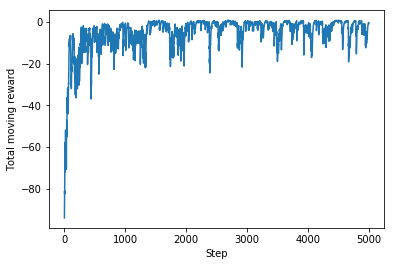

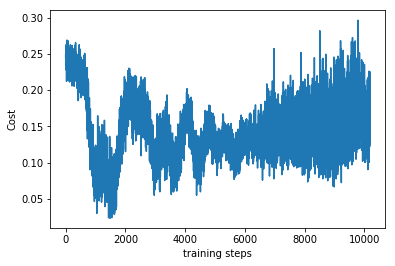

In [25]:
t0 = time.time()
tf.reset_default_graph() 
RL = DeepQNetwork(env)
step = 0
for episode in range(5000):
        # initial observation
    state = env.reset()
    ep_r = 0
    
    step_ini = step
    while step - step_ini <= 100 :
        # RL choose action based on observation
        action = RL.choose_action(state)

        # RL take action and get next observation and reward
        next_state, reward, done = env.step(state,action)
        ep_r += reward
        RL.store_transition(state, action, reward, next_state)

        if (step > 200) and (step % 5 == 0):
            RL.learn()

        # swap observation
        state = next_state

        # break while loop when end of this episode
        if done or step - step_ini == 100 :
            if len(RL.moving_rewards) == 0:  # record running episode reward
                RL.moving_rewards.append(ep_r)
            else:
                RL.moving_rewards.append(0.9 * RL.moving_rewards[-1] + 0.1 * ep_r)
            RL.episode_count += 1
            break
        step += 1

print("Computational time : ",time.time()-t0)
        
RL.plot_avg_moving_rwd('DQN_avg_moving_rwd')

RL.plot_cost()

In [26]:
RL.compute_policy()
RL.render_policy()

RL.compute_q()
render_q(RL.env,RL.q)

## REPS algorithm
### Pseudocode implementation in docs file

In [83]:
class REPS(RLModel):
    def __init__(self, env, p=3, N=100,K=50,eta=0.1):
        RLModel.__init__(self, env)
        self.p = p
        self.N = N
        self.K = K
        self.eta = eta
    
    def compute_new_policy(self, eta, policy, phi, theta, samples):
        log_new_pi = np.zeros((policy.n_states,policy.n_actions))
        A = np.zeros((policy.n_states,policy.n_actions))
        counter = np.zeros((policy.n_states,policy.n_actions))
        nb_samples = 0
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            for j in range(len(states)):
                A[states[j],actions[j]] += rewards[j] + np.dot(phi[next_states[j],:],theta) - np.dot(phi[states[j],:],theta)
                counter[states[j],actions[j]] += 1
                nb_samples += 1
        for s in range(env.n_states):
            for a in range(env.n_actions):
                if counter[s,a]!=0:
                    A[s,a] /= counter[s,a]
        for s in range(policy.n_states):
            for a in range(policy.n_actions):
                argexpo = np.zeros(policy.n_actions)
                if policy.pi[s,a] == 0:
                    log_new_pi[s,a] = -float('inf')
                else:
                    for b in range(policy.n_actions):
                        argexpo[b] = np.log(policy.pi[s,b]+0.0001) + eta * A[s,b]
                    maxi = np.max(argexpo)
                    log_new_pi[s,a] = argexpo[a] - np.log(np.sum(np.exp(argexpo - maxi))) - maxi
        return(Policy(np.exp(log_new_pi)))


    def g(self, theta, eta, phi, samples):
        res = 0
        A = np.zeros((env.n_states,env.n_actions))
        counter = np.zeros((env.n_states,env.n_actions))
        nb_samples = 0
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            for j in range(len(states)):
                A[states[j],actions[j]] += rewards[j] + np.dot(phi[next_states[j],:],theta) - np.dot(phi[states[j],:],theta)
                counter[states[j],actions[j]] += 1
                nb_samples += 1
        for s in range(env.n_states):
            for a in range(env.n_actions):
                if counter[s,a]!=0:
                    A[s,a] /= counter[s,a]
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            for j in range(len(states)):
                res += np.exp(eta*A[states[j],actions[j]])
        res /= nb_samples
        return (np.log(res)/eta)

    def Dg(self, theta, eta, phi, samples):
        n_states,p = np.shape(phi)
        numerator = 0
        denominator = 0
        A = np.zeros((env.n_states,env.n_actions))
        D = np.zeros((env.n_states,env.n_actions,p))
        counter = np.zeros((env.n_states,env.n_actions))
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            for j in range(len(states)):
                A[states[j],actions[j]] += rewards[j] + np.dot(phi[next_states[j],:],theta) - np.dot(phi[states[j],:],theta)
                D[states[j],actions[j],:] += phi[next_states[j],:] - phi[states[j],:]
                counter[states[j],actions[j]] += 1
        for s in range(env.n_states):
            for a in range(env.n_actions):
                if counter[s,a]!=0:
                    A[s,a] /= counter[s,a]
        for s in range(env.n_states):
            for a in range(env.n_actions):
                if counter[s,a]!=0:
                    D[s,a,:] /= counter[s,a]
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            for j in range(len(states)):
                numerator += np.exp(eta*A[states[j],actions[j]]) * D[states[j],actions[j]]
                denominator += np.exp(eta*A[states[j],actions[j]])
        return ((1/eta) * numerator / denominator)

    def compute_phi(self,p):
        phi = np.zeros((self.env.n_states,p))
        for k in range(self.env.n_states):
            phi[k,:] = [k,k**2,np.log(k+1)]
        return phi

    def policy_update(self):
        """Relative Entropy Policy Search using Mirror Descent"""
        p = 3    
        # initialization of the distribution
        pi = self.initialize_pi()
        policy = Policy(pi)
        #Tmax =  -100*np.log(10e-6)/(1-env.gamma)
        T = 100
        theta = [0 for i in range(p)]
        phi = self.compute_phi(p)
        
        for k in tqdm(range(self.K), desc="Iterating REPS algorithm..."):
            ##### SAMPLING
            samples = self.collect_episodes(policy=policy,horizon=T,n_episodes=self.N)

            #### OPTIMIZE
            theta = opt.fmin_bfgs(self.g,x0=theta,fprime=self.Dg,args=(self.eta,phi,samples), disp=0)

            #### COMPUTE THE NEW POLICY
            policy = self.compute_new_policy(self.eta,policy,phi,theta,samples) 
            
        self.policy = policy
        self.theta = theta
        self.phi = phi
        
    

In [84]:
REPS_model = REPS(env)
REPS_model.policy_update()

Iterating REPS algorithm...: 100%|█████████████████████████████████████████████████████| 50/50 [08:44<00:00, 17.35s/it]


In [16]:
REPS_model.render_policy()

In [ ]:
REPS_model.plot_avg_moving_rwd('REPS_avg_moving_rwd')

## DPP-RL Algorithm 
### based on the paper "Dynamic Policy Programming" in docs file

In [37]:
class DPP(RLModel):
    
    def __init__(self, env, K=50, eta=0.1):
        RLModel.__init__(self, env)
        self.K = K
        self.eta = eta

    def update_pi(self, pi, phi):
        n_states,n_actions = np.shape(pi)
        pi = np.zeros((n_states,n_actions))
        for s in range(n_states):
            pi[s,:] = np.exp(self.eta * phi[s,:])
            pi[s,:] /= np.sum(pi[s,:])*np.ones(n_actions)
        return(pi)

    def compute_Mphi(self, phi):
        n_states,n_actions = np.shape(phi)
        Mphi =  np.zeros(n_states)
        for s in range(n_states):
            numerator = 0
            denominator = 0
            for a in range(n_actions):
                numerator += np.exp(self.eta*phi[s,a]) * phi[s,a]
                denominator += np.exp(self.eta*phi[s,a])
            Mphi[s] = numerator / denominator
        return(Mphi)

    def update_phi(self, pi, phi):
        n_states,n_actions = np.shape(pi)
        Mphi = self.compute_Mphi(phi)
        for s in range(n_states):
            for a in range(n_actions):
                next_state, reward, _ = self.env.step(action=a,state=s)
                bellman_op = reward + self.env.gamma * Mphi[next_state]
                phi[s,a] += bellman_op - Mphi[s]
        return phi

    def policy_update(self):
        pi = self.initialize_pi()
        phi = np.ones((self.env.n_states, self.env.n_actions))
        
        for k in tqdm(range(self.K), desc="Iterating DPP algorithm..."):
            phi = self.update_phi(pi, phi)
            pi = self.update_pi(pi, phi)
            
        self.policy = Policy(pi)
        self.phi = phi
        

In [38]:
DPP_model = DPP(env)
DPP_model.policy_update()

Iterating DPP algorithm...: 100%|█████████████████████████████████████████████████████| 50/50 [00:00<00:00, 640.03it/s]


In [35]:
DPP_model.render_policy()

# TRPO

In [92]:
class TRPO(RLModel):
    def __init__(self, env, K=200, N = 100, eta=0.1):
        RLModel.__init__(self, env)
        self.K = K
        self.N = N
        self.eta = eta

    def compute_Q(self, samples, Q):
        n_states,n_actions = np.shape(Q)
        counter = np.zeros((n_states,n_actions))
        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            cumulated_rwd = 0
            for j in range(len(states)):
                t = len(states) -1 - j
                cumulated_rwd = self.env.gamma * cumulated_rwd + rewards[t]
                Q[states[t],actions[t]] += cumulated_rwd
                counter[states[t],actions[t]] += 1

        for s in range(n_states):
            for a in range(n_actions):
                if counter[s,a]!=0:
                    Q[s,a] /= counter[s,a]
        return Q


    def compute_value_function(self, Q, pi):
        n_states,n_actions = np.shape(Q)
        V = np.zeros(n_states)
        for s in range(n_states):
            for a in range(n_actions):
                V[s] += pi[s,a] * Q[s,a]
        return V

    def compute_advantage_function(self, pi, V, samples):
        n_states, n_actions = np.shape(pi)
        A = np.zeros((n_states,n_actions))
        counter = np.zeros((n_states,n_actions))

        for i in range(len(samples)):
            states = samples[i]['states']
            actions = samples[i]['actions']
            rewards = samples[i]['rewards']
            next_states = samples[i]['next_states']

            for j in range(len(states)):
                A[states[j],actions[j]] += rewards[j] + V[next_states[j]] - V[states[j]]
                counter[states[j],actions[j]] += 1

        for s in range(n_states):
            for a in range(n_actions):
                if counter[s,a]!=0:
                    A[s,a] /= counter[s,a]
        return A

    def update_pi(self, pi, A):
        n_states,n_actions = np.shape(pi)
        for s in range(n_states):
            for a in range(n_actions):
                pi[s,a] *= np.exp(self.eta * A[s,a]) 
            pi[s,:] /= np.sum(pi[s,:])
        return(pi)


    def policy_update(self):
        pi = self.initialize_pi()
        A = np.ones((env.n_states,env.n_actions))
        Q = np.ones((env.n_states,env.n_actions))
        V = np.ones(env.n_states)
        T = 100
        for k in tqdm(range(self.K), desc="Iterating TRPO algorithm..."):
            policy = Policy(pi)
            ##### SAMPLING
            samples = self.collect_episodes(policy=policy,horizon=T,n_episodes=self.N)  

            #### COMPUTE Q FUNCTION
            Q = self.compute_Q(samples,Q)

            #### COMPUTE VALUE FUNCTION
            V = self.compute_value_function(Q,pi)

            #### COMPUTE ADVANTAGE FUNCTION
            A = self.compute_advantage_function(pi,V,samples)

            #### COMPUTE THE NEW POLICY
            pi = self.update_pi(pi, A)  
            
        self.policy = Policy(pi)
        self.A = A
        self.V = V
        self.Q = Q
        

In [93]:
TRPO_model = TRPO(env)
TRPO_model.policy_update()

Iterating TRPO algorithm...: 100%|███████████████████████████████████████████████████| 200/200 [00:04<00:00, 43.84it/s]


In [64]:
TRPO_model.render_policy()

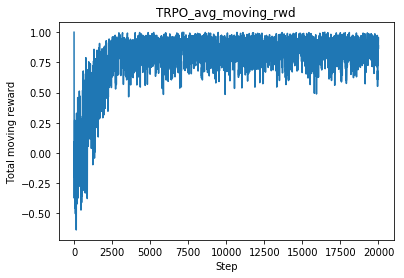

In [94]:
TRPO_model.plot_avg_moving_rwd('TRPO_avg_moving_rwd')

# A3C

In [79]:
class A3C(TRPO):
    def __init__(self, env, K=320, N = 100, eta=0.1):
        TRPO.__init__(self, env, K, N, eta)
        self.K = K
        self.N = N
        self.eta_init = eta

    def update_pi(self, pi, A):
        n_states,n_actions = np.shape(pi)
        for s in range(n_states):
            for a in range(n_actions):
                pi[s,a] = np.exp(self.eta * A[s,a]) 
            pi[s,:] /= np.sum(pi[s,:])
        return(pi)
    
    def update_eta(self):
        self.eta += self.eta_init

    def policy_update(self):
        pi = self.initialize_pi()
        A = np.ones((env.n_states,env.n_actions))
        Q = np.ones((env.n_states,env.n_actions))
        V = np.ones(env.n_states)
        T = 100
        for k in tqdm(range(self.K), desc="Iterating A3C algorithm..."):
            ##### UPDATING ETA
            self.update_eta()
            
            ##### CONSTRUCTING POLICY
            policy = Policy(pi)
            
            ##### SAMPLING
            samples = self.collect_episodes(policy=policy,horizon=T,n_episodes=self.N)  

            #### COMPUTE Q FUNCTION
            Q = self.compute_Q(samples,Q)

            #### COMPUTE VALUE FUNCTION
            V = self.compute_value_function(Q,pi)

            #### COMPUTE ADVANTAGE FUNCTION
            A = self.compute_advantage_function(pi,V,samples)

            #### COMPUTE THE NEW POLICY
            pi = self.update_pi(pi, A)  
            
        self.policy = Policy(pi)
        self.A = A
        self.V = V
        self.Q = Q
        

In [80]:
A3C_model = A3C(env)
A3C_model.policy_update()

Iterating A3C algorithm...: 100%|████████████████████████████████████████████████████| 320/320 [00:14<00:00, 21.99it/s]


In [82]:
A3C_model.render_policy()

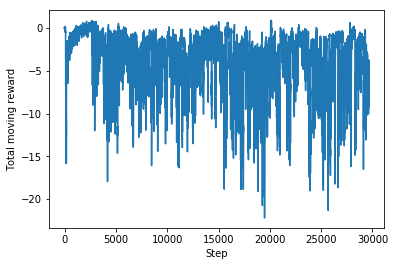

In [81]:
A3C_model.plot_avg_moving_rwd('A3C_avg_moving_rwd')